# Data Analysis of Olivocerebellar Model

## Table of Contents
### 1. Import All
    1. Import packages
    2. Import data of simulations
### 2. Split Data - Before/After Adaptation
### 3. Purkinje Cell 
    1. Input current
    2. 
### 4. Inferior Olive
    1.
### 5. Correlations/Delays
    1. IO - IO 
### 6. Complex Spike Analysis
    1. PC current input
    2. Voltage of IO cell
    

## 1. Import All

In [1]:
# 1.1) Import packages
import numpy as np
from importlib import reload
from brian2 import*
import pickle
import NeuroTools as nt
from NeuroTools import signals, analysis
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import scipy.io as sio
import seaborn as sns
import matplotlib.patches as mpatches
#import plotpy.express as px

# Import and reload my helpers module for iterative development
import helpers
reload(helpers)
from helpers.Function_DataAnalysis import *

# default dict. to assign values
from collections import defaultdict

with open('PV.pickle', 'rb') as par:
    PV = pickle.load(par)
with open('SpikeTimes.pickle', 'rb') as st:
    SpikeTimes = pickle.load(st)
with open('VoltCell.pickle', 'rb') as vc:
    VoltCell = pickle.load(vc)
with open('Input.pickle', 'rb') as inp:
    Input = pickle.load(inp)
#print(PV['a_PC'][1])
# 1.2) Import data of simulations
#nameInput = 'InputDS_5Diff'
#name_simparam = nameInput + '_SimParams'
#name_VoltCell = nameInput + '_VoltageCell'
#name_SpikeT = nameInput + '_SpikeTimes'
#name_PV = nameInput + '_PlasticityVariables'
#name_Input = nameInput + 'AfterSim'

#SimParam = sio.loadmat(name_simparam)
#VoltCell = sio.loadmat(name_VoltCell)
#SpikeTimes = sio.loadmat(name_SpikeT)
#PlasticityVar = sio.loadmat(name_PV)
#Input = sio.loadmat(name_Input)
print(len(Input['I']))

5


## 2. Split Data - Before/After Adaptation

In [2]:
# 2) Split Data - before/after adaptation    

# before = start_t:t_beforeAdaptation
# after = t_beforeAdaptaion:end
# indicated by BA (BeforeAdaptation) and AA (AfterAdaptation) accordingly


start = 1000 # remove first second of data due to transient
t_beforeAdaptation = int(len(Input['I'][1])/2)


#int(len(Input['Input']['I'][0][0][0])/2) # halfway the simulation
nrInputs=Input['I'].shape[0] # number of inputs
print(nrInputs)
nrPC = VoltCell['PC'].shape[0]
nrDCN = VoltCell['DCN'].shape[0]
nrIO = VoltCell['IOsoma'].shape[0]
nrDummy = nrPC*nrInputs
lengthSim =VoltCell['PC'].shape[1]
print(start,t_beforeAdaptation)
BeforeAdaptation = {}
# Input to the system
Input = Slicing(Input, t_start=start)
Input_BA = Slicing(Input, t_start=start, t_end=t_beforeAdaptation)
Input_AA = Slicing(Input, t_start=t_beforeAdaptation)

# Voltages of Cells
VoltCell_ = Slicing(VoltCell, t_start=start)
VoltCell_BA = Slicing(VoltCell, t_start=start, t_end=t_beforeAdaptation)
VoltCell_AA = Slicing(VoltCell, t_start=t_beforeAdaptation)
print(VoltCell['IOsoma'][1])
for k in range(0,nrIO):
    #IOnr = 'IO'+str(k)
    findspikes, _ = find_peaks(VoltCell['IOsoma'][k], height=0.0, distance = 10) 
    findspikes = findspikes/1000
    SpikeTimes['IO'][k]=findspikes
# Slicing spike times
SpikeTimes_BA = SlicingSpikes(SpikeTimes, t_start=start/1e3, t_end=t_beforeAdaptation/1e3)
SpikeTimes_AA = SlicingSpikes(SpikeTimes, t_start=t_beforeAdaptation/1e3)
#findspikes, _ = find_peaks(VoltCell['VoltCell']['IOsoma'][0][0][p], height=0.0, distance = 10)
#findspikes = findspikes/1000
print(SpikeTimes_BA['IO'][9])

5
1000 2500
[  0.         -41.41747363 -37.26194434 ... -69.19286457 -69.15085039
 -69.12014426] mV
[1.022 1.217 1.413 1.608 1.803 2.    2.195 2.39 ]


### 3. Purkinje Cell

In [3]:
# 3.1 Input current 

InputCurrentPC={}
InputCurrentPC_BA={}
InputCurrentPC_AA={}

for i in range(0,nrPC):
    # Create names for the inputs
    name = 'PC'+str(i)
    nameBA = 'PC'+str(i) + 'BA'
    nameAA = 'PC'+str(i) + 'AA'
    
    tot = name + 'total'
    totBA = nameBA + 'total'
    totAA = nameAA + 'total'
    # Connectivity between PC-dummy
    steps =np.arange(i,nrDummy,nrPC)
    # Multiply the current times the weight
    current = [Input['I'][k]*Input['nweight'][steps[k]] for k in range(0,len(steps))]
    currentBA = [Input_BA['I'][k]*Input_BA['nweight'][steps[k]] for k in range(0,len(steps))]
    currentAA = [Input_AA['I'][k]*Input_AA['nweight'][steps[k]] for k in range(0,len(steps))]
    #[Input_s.nweight_BA[steps[k]]*Input_s.I_BA[k] for k in range(0,len(steps))]
    #print(steps[1])
    #print(size(Input_s.nweight_BA[0]))
    #print(size(current))
    # Sum over the column to get the total amount of current
    summedcurrent = sum(current,axis=0)
    summedcurrentBA = sum(currentBA, axis=0)
    summedcurrentAA = sum(currentAA, axis=0)
    
    InputCurrentPC[name] = current
    InputCurrentPC_BA[nameBA] = currentBA
    InputCurrentPC_AA[nameAA] = currentAA
    
    InputCurrentPC[tot] = summedcurrent
    InputCurrentPC_BA[totBA] = summedcurrentBA
    InputCurrentPC_AA[totAA] = summedcurrentAA



### 5. Correlations

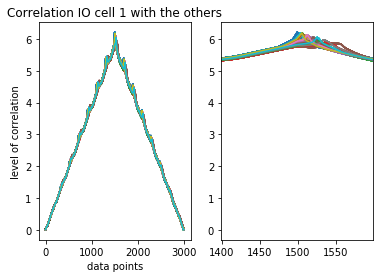

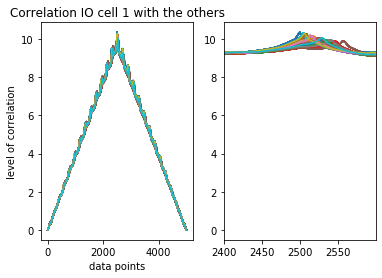

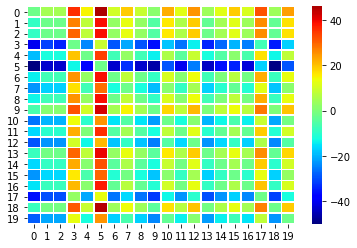

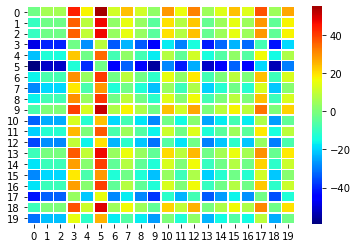

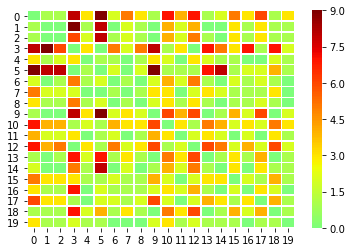

In [4]:
delayIO_BA = np.empty([nrIO,nrIO])
delayIO_AA = np.empty([nrIO,nrIO])
diffDelay = np.empty([nrIO,nrIO])
for i in range(0,nrIO):
    # Correlation Before Adapatation
    corr_BA=[correlate(VoltCell_BA['IOsoma'][i],VoltCell_BA['IOsoma'][k],'full') for k in range(0,nrIO)]
    corr_AA=[correlate(VoltCell_AA['IOsoma'][i],VoltCell_AA['IOsoma'][k],'full') for k in range(0,nrIO)]
    #print(corr_BA)
    #print(len(VoltCell_s.IOsoma_AA[i]))
    #lagIO_BA=numpy.where(corr_BA[i] == numpy.amax(corr_BA[i]))
    
    lagTotal_BA = [corr_BA[k].argmax()-len(VoltCell_BA['IOsoma'][i])-1 for k in range(0,nrIO)]
    lagTotal_AA = [corr_AA[k].argmax()-len(VoltCell_AA['IOsoma'][i])-1 for k in range(0,nrIO)]
    #print(lagTotal_AA)
    #lagTotal_BA = asarray([(asarray(lagRest_BA[k][0])-asarray(lagIO_BA[0][0])) for k in range(0,nrIO)])
    #lagTotal_BA = lagTotal_BA.reshape(nrIO)
    #print(lagIO_BA)
#print(lagRest_BA)
#print(lagTotal_BA)
    #lagIO_AA=numpy.where(corr_AA[i] == numpy.amax(corr_AA[i]))
    #lagRest_AA = [numpy.where(corr_AA[k] == numpy.amax(corr_AA[k])) for k in range(0,nrIO)]
    #lagTotal_AA = asarray([(asarray(lagRest_AA[k][0])-asarray(lagIO_AA[0][0])) for k in range(0,nrIO)])
    #lagTotal_AA = lagTotal_AA.reshape(nrIO)

    delayIO_BA[i] = lagTotal_BA
    delayIO_AA[i] = lagTotal_AA
    
    if i==0:
        plt.subplot(121)
        for l in range(0,nrIO):
            plt.plot(transpose(corr_BA))
        #print(len(corr_A[0]))
        #print(len(corr_BA))
        plt.title('Correlation IO cell 1 with the others')
        plt.xlabel('data points')
        plt.ylabel('level of correlation')
        ax1=plt.subplot(122)
        for l in range(0,nrIO):
            plt.plot(transpose(corr_BA))
        ax1.set_xlim([corr_BA[i].argmax()-100, corr_BA[i].argmax()+100])
        #ax1.set_ylim([5,7])
        plt.show()
        plt.subplot(121)
        for l in range(0,nrIO):
            plt.plot(transpose(corr_AA))
        #print(len(corr_A[0]))
        #print(len(corr_BA))
        plt.title('Correlation IO cell 1 with the others')
        plt.xlabel('data points')
        plt.ylabel('level of correlation')
        ax1=plt.subplot(122)
        for l in range(0,nrIO):
            plt.plot(transpose(corr_AA))
        ax1.set_xlim([corr_AA[i].argmax()-100, corr_AA[i].argmax()+100])
        #ax1.set_ylim([1,3])       
            
            
    #print(lagTotal_AA[:])

    diffDelay[i] = abs(asarray(lagTotal_AA)-asarray(lagTotal_BA))


figure()
ax = sns.heatmap(delayIO_BA, center=0,cmap='jet',linewidths=.5)

figure()
sx = sns.heatmap(delayIO_AA, center=0, cmap='jet', linewidths=.5)

figure()
df = sns.heatmap(diffDelay,center=0, cmap='jet', linewidths=.5)


### 6. Complex Spike Analysis

In [5]:
# 6.1 Input Current Purkinje Cell
# Get the current that the Purkinje cell sees 150 ms before and 50 ms after
# a complex spike of the connected Inferior Olive

# The IO cells that are connected to the Purkinje cells. 
# Position 1 of the vector corresponds to PC1, 2 to PC2 etc.
connectionVectorIO = [9,10, 18, 17, 0, 6, 5, 12, 16, 11]

time_before_spike = 150e-3
time_after_spike = 50e-3
CS_currentPC=defaultdict(dict)
dur=int((time_before_spike+time_after_spike)/1e-3)
#print(dur)
meancur_BA=np.zeros((nrPC,dur))
meancur_AA=np.zeros((nrPC,dur))

meancur_VBA=np.zeros((nrPC,dur))
meancur_VAA=np.zeros((nrPC,dur))
#print(meancur.shape)
for jj in range(0,nrPC):
    strpc = str(jj)
    strp = str(connectionVectorIO[jj])
    ionr = 'BA_IO'+strp
    pcnr = 'PC'+strpc+'total'
    #SpikesIO = SpikeTimes_s.ionr
    InputCurr = InputCurrentPC[pcnr]
    VoltPC = VoltCell_['PC'][jj]
    print(VoltPC)

    CS_BA= SpikeTimes_BA['IO'][connectionVectorIO[jj]]
    CS_AA = SpikeTimes_AA['IO'][connectionVectorIO[jj]]

    #print(len(InputCurr))
    empt_BA =np.zeros((len(CS_BA),dur))
    empt_AA =np.zeros((len(CS_AA),dur))
    
    empt_VBA =np.zeros((len(CS_BA),dur))
    empt_VAA =np.zeros((len(CS_AA),dur))
    for ii in range(0,len(CS_BA)):
        begin_analysis = int(((CS_BA[ii]-time_before_spike)/1e-3 - 1000))
        end_analysis = int((min((CS_BA[ii]+time_after_spike)/1e-3,
                        len(InputCurr)+1000)-1000))
        #print(end_analysis-begin_analysis)
        
        if (end_analysis-abs(begin_analysis))==200 :
            CS_currentPC[ionr][ii] = InputCurr[begin_analysis:end_analysis]
            empt_BA[ii]= InputCurr[begin_analysis:end_analysis]
            empt_VBA[ii]=VoltPC[begin_analysis:end_analysis]
            
            
    for kk in range(0,len(CS_AA)):
        begin_analysis = int(((CS_AA[kk]-time_before_spike)/1e-3 - 1000))
        end_analysis = int((min((CS_AA[kk]+time_after_spike)/1e-3,
                        len(InputCurr)+1000)-1000))
        #print(end_analysis-begin_analysis)
        
        if (end_analysis-abs(begin_analysis))==200 :
            CS_currentPC[ionr][kk] = InputCurr[begin_analysis:end_analysis]
            empt_AA[kk]= InputCurr[begin_analysis:end_analysis] 
            empt_VAA[kk]=VoltPC[begin_analysis:end_analysis]

                       
                #print('not full time - too close to beginning')
    #print('shape_BA',empt_BA.shape)
    #print('shape AA',empt_AA.shape)
    empt_BA = empt_BA[~all(empt_BA==0, axis=1)]
    empt_AA = empt_AA[~all(empt_AA==0, axis=1)]
    empt_VBA = empt_VBA[~all(empt_VBA==0, axis=1)]
    empt_VAA = empt_VAA[~all(empt_VAA==0, axis=1)]
    #print('AA =',empt_AA)
    #print('BA = ',empt_BA)
    #empt=argwhere(empt)
    #print(empt)
    meancur_BA[jj] = mean(empt_BA,axis=0)
    meancur_AA[jj] = mean(empt_AA,axis=0)
    meancur_VBA[jj] =mean(empt_VBA,axis=0)
    meancur_VAA[jj] =mean(empt_VAA,axis=0)

    #print('mean input current =',mean(empt,axis=0))

[-58.08277472 -53.05351959 -48.52313745 ... -50.50356261 -48.07829549
 -68.24380278] mV
[-59.31362027 -54.33010408 -50.09583278 ... -49.90503669 -46.77167433
 -65.89122332] mV
[-53.95044842 -49.99739889 -43.12754756 ... -50.12416609 -47.65754114
 -68.40880233] mV
[-60.21023083 -59.53053916 -58.53775059 ... -48.67889378 -69.57429155
 -62.33077905] mV
[-55.78714655 -51.90792323 -47.91499821 ... -52.40170106 -50.8788868
 -48.80533782] mV
[-61.2269299  -56.02058235 -51.91239013 ... -45.81396132 -65.64111868
 -59.49997467] mV
[-61.28962197 -59.87963079 -58.44014103 ... -67.52640515 -61.04744795
 -56.23689666] mV
[-54.08879229 -50.63474219 -46.00155687 ... -46.35076512 -65.45093657
 -59.57396857] mV
[-52.60749779 -49.28838284 -69.58712027 ... -46.45473402 -65.53196453
 -59.55297093] mV
[-58.01063745 -54.04054238 -50.82592231 ... -49.72927812 -47.61371364
 -67.22217488] mV


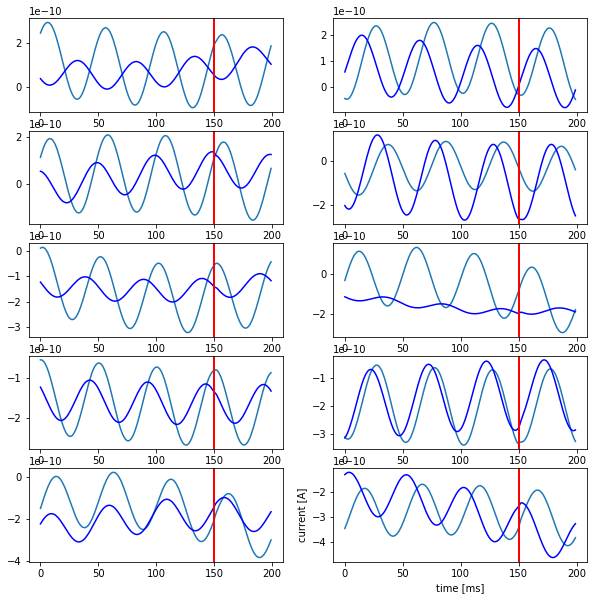

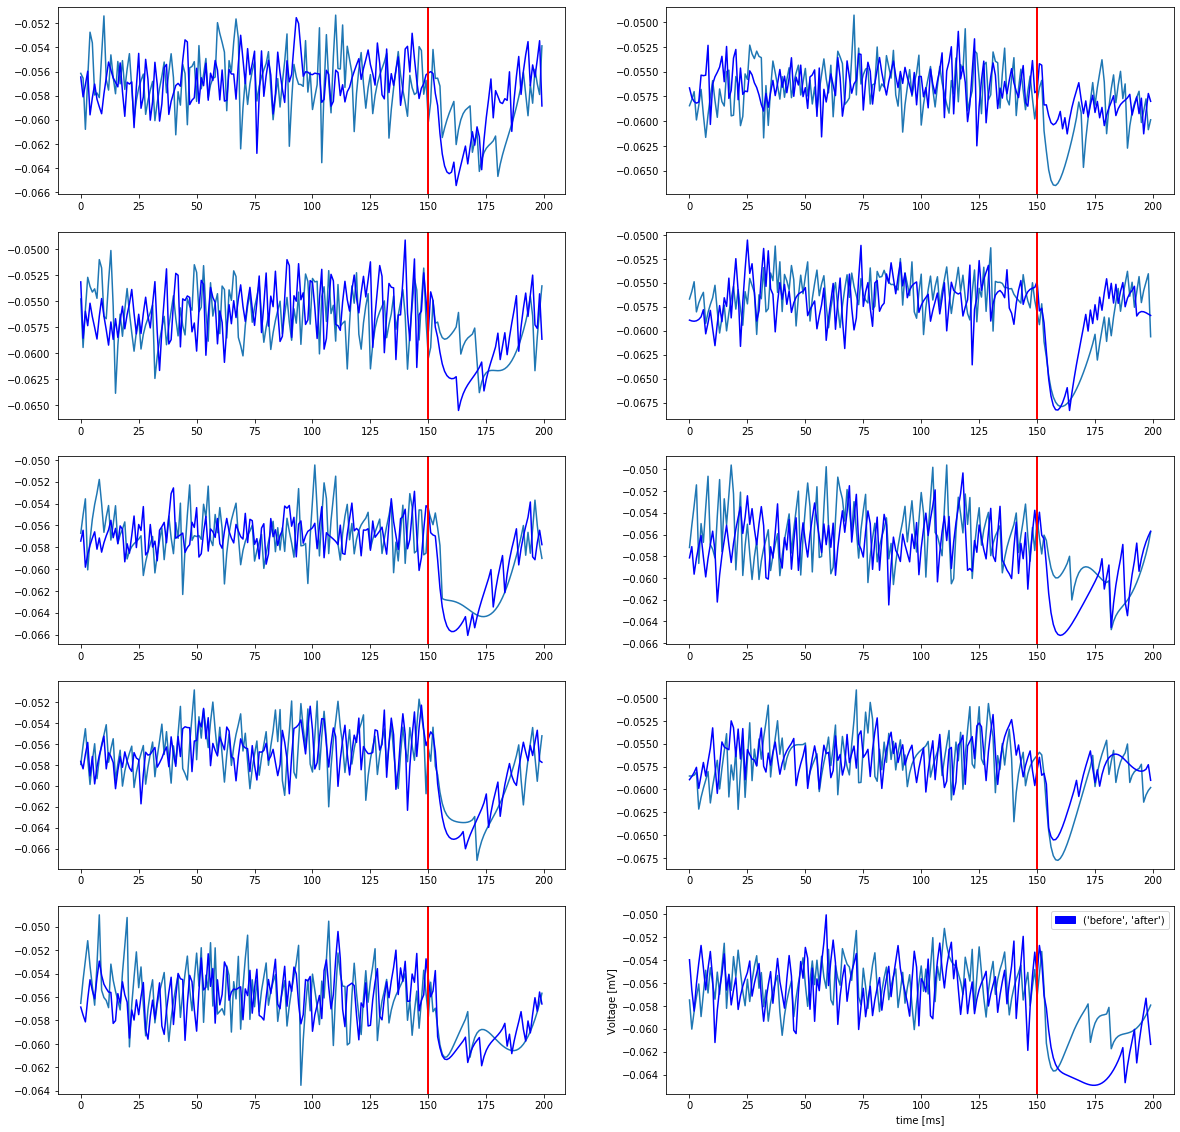

In [11]:
figure(figsize=(10,10))
for i in range(0,len(meancur_BA)):
    subplot(5,2,i+1)
    #print(meancur_AA[i])
    plot(meancur_BA[i])
    plot(meancur_AA[i],color='b')
    axvline(150, linewidth=2,color='r')
#legend('before','after','cs', loc='lower left')
xlabel('time [ms]')
ylabel('current [A]')
show()
figure(figsize=(20,20))
for i in range(0,len(meancur_VBA)):
    subplot(5,2,i+1)
    #print(meancur_AA[i])
    plot(meancur_VBA[i])
    plot(meancur_VAA[i],color='b')
    axvline(150, linewidth=2,color='r')
red_patch = mpatches.Patch(color='blue', label=('before','after'))
legend(handles=[red_patch])
xlabel('time [ms]')
ylabel('Voltage [mV]')
show()

In [ ]:
food = 'bread'

vars()[food] = 123
print(vars())
print(bread)  # --> 123

In [ ]:
import pickle

# An arbitrary collection of objects supported by pickle.
data = {
    'a': [1, 2.0, 3, 4+6j],
    'b': ("character string", b"byte string"),
    'c': {None, True, False},
    'd': [[1,2],[2,4],[3,9]]
}

with open('data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
print(data)

In [ ]:
with open('data.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data = pickle.load(f)
print(data['d'][1])

In [ ]:
size(VoltCell_AA['IOsoma'][1])+100
corr_BA=[correlate(VoltCell_BA['IOsoma'][0],VoltCell_BA['IOsoma'][k],'full') for k in range(0,nrIO)]